# JUMP2DIGITAL | Reparto a domicilio

---

Andreu Vall Hernàndez

## 1. ¿Cuáles son los 3 paises en los que más pedidos se realizan?

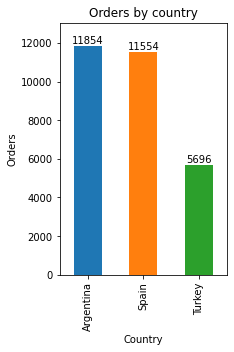

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the train set
df = pd.read_csv('train.csv')

numb_countries = 3

# Convert country code to country name using data from https://datahub.io/core/country-list
country_code_table = pd.read_csv('country_code.csv')
country_code_dic = {row.Code: row.Name for _, row in country_code_table.iterrows()}

top_countries = df.country_code.value_counts()
top_countries.index = (country_code_dic[idx] for idx in top_countries.index)

plt.figure(figsize=(numb_countries, 4))
plt.title('Orders by country')
plt.ylabel('Orders')
plt.xlabel('Country')
plt.subplots_adjust(top=1)

ax = top_countries[:numb_countries].plot(kind='bar', color=plt.cm.tab10(range(numb_countries)))
ax.bar_label(ax.containers[0])
ax.set_ymargin(.1)

## 2. ¿Cuáles son las horas en las que se realizan más pedidos en España?

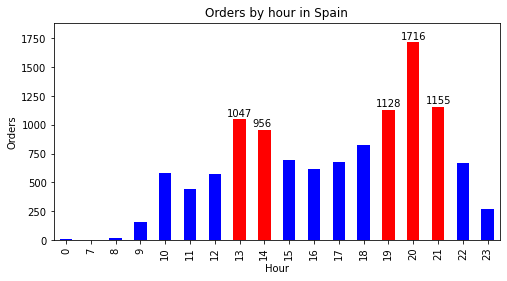

In [2]:
# Add local_hour row saving only the hour as an integer
df.insert(2, 'local_hour', df.local_time.str.slice(0, 2).astype('int'))

sp = df[df.country_code=='ES'].copy()
sp_hour_orders = sp.local_hour.value_counts().sort_index()

numb_busy_hours = 5
sep_value = sorted(sp_hour_orders, reverse=True)[numb_busy_hours-1]

clrs = ['red' if x>=sep_value else 'blue' for x in sp_hour_orders]

plt.figure(figsize=(8, 4))
plt.title('Orders by hour in Spain')
plt.ylabel('Orders')
plt.xlabel('Hour')

ax = sp_hour_orders.plot(kind='bar', color=clrs)
ax.set_ymargin(.1)
for i, v in enumerate(sp_hour_orders):
    if v >= sep_value:
        ax.text(i-.5, v+30, str(v))

Hay dos picos de demanda, el más alto es a las 20h y dura 3h, mientras que el otro es a las 13h y dura 2h.

## 3. ¿Cuál es el precio medio por pedido en la tienda con ID 12513?

El precio medio por pedido en la tiena con ID 12513 es de 17.3922


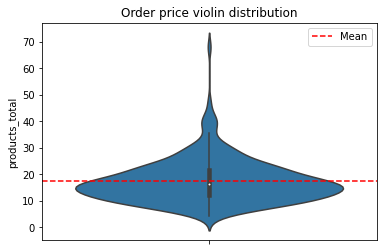

In [3]:
import seaborn as sns

store_id = 12513

store = df[ df.store_address == store_id ]
plt.title('Order price violin distribution')

mean = store.products_total.mean()

ax = sns.violinplot(y="products_total", data=store)
ax.axhline(mean, color='r', linestyle='--', label="Mean")
ax.legend()

print('El precio medio por pedido en la tiena con ID', store_id, 'es de', round(mean, 4))

## 4. ¿Qué porcentaje de repartidores pondrías por cada turno de 8h?

Teniendo en cuenta los picos de demanda en España, si los repartidores trabajan en turnos de 8 horas:

- Turno 1 (00:00-08:00)
- Turno 2 (08:00-16:00)
- Turno 3 (16:00-00:00)

¿Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda? (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%).

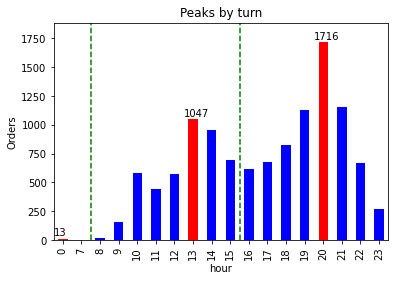

In [14]:
# First we visualitze the peaks for each turn in a similar way as question 2

hours = pd.DataFrame(sp_hour_orders)
hours.index.name = 'hour'
hours.columns = ['orders']
hours['turn'] = 'Turn ' + (hours.index//8 + 1).astype('str')

peak = hours.groupby('turn').max()
clrs = ['blue'] * hours.shape[0]
for i, idx_row in enumerate(hours.iterrows()):
    row = idx_row[1]
    if row.orders == peak.loc[row.turn].orders:
        clrs[i] = 'red'

plt.ylabel('Orders')
plt.title('Peaks by turn')

ax = hours.orders.plot(kind='bar', color=clrs)
ax.set_ymargin(.1)
ax.axvline(1.5, color='g', linestyle='--')
ax.axvline(9.5, color='g', linestyle='--')

for i, v in enumerate(sp_hour_orders):
    if clrs[i]=='red':
        ax.text(i-.5, v+30, str(v))

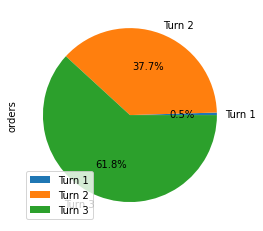

In [15]:
ax = hours.groupby('turn').max().plot(kind='pie', autopct='%1.1f%%', subplots=True)

Si queremos poner el número de trabajadores por turno directament proporcional a los picos de demanda del turno, nos sale un 0.5%, 37.7% y 61.8% para los turnos 1, 2 y 3 respectivamente.

Como hay tan pocos pedidos en el turno de 0 a 8 habría que aclarir si se puede hacer o no un pedido en esas horas, es decir, decidir si dejar o no un turno mínimo nocturno. En caso de dejarlo, quizá habría que augmentar el 0.5% a un 2% (los otros quedarían 37% y 61%), ya que si tenemos menos de 100 repartidoes no tocaría ninguno y por si algún día puediese salir algún imprevisto.

La ratio de trabajadores en los otros dos turnos parece bastante razonable, ya que aparte de ser proporcional al pico, viendo el gráfico se corresponde también aproximadamente a la ratio de pedidos totales por turno.

## 5. Modelo predictivo de machine learning para predecir si un pedido se cancelará o no

### 5.1. Goal Analysis

First of all let's load the training data and analyze the variable we want to predict: whether an order will be canceled or not, marked by DeliveredStatus or CanceledStatus.

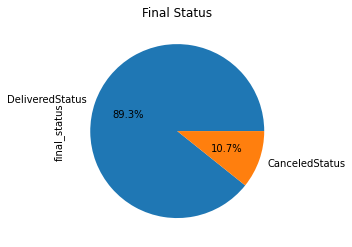

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')
plt.title('Final Status')

ax = data.final_status.value_counts().plot(kind='pie', autopct='%1.1f%%')

We can see that we have approximately a 9 : 1 imbalanced dataset (only about 10.7% of the orders have been canceled).

We want to predict whether a new order will be canceled or not, and we particulary care about identifying these canceled orders to save company costs. What metric will we use to measure the performance of a model? If we used simply accuracy or regular f1 score, by simply predicting that all orders will be Delivered we could achieve about 90% score, but that would be useless.

That's why we'll use f1 macro score to evaluate our models, an average of the f1 score between the DeliveredStatus and CanceledStatus, which means that 10% of data (CanceledStatus) will matter around 50% in our metric.

In [81]:
# Scores just predicting Delivered (1)

from sklearn.metrics import f1_score

y = (data.final_status=='DeliveredStatus').astype('int')

print('normal f1 score:', f1_score(y, [1]*y.shape[0]))
print('macro  f1 score:', f1_score(y, [1]*y.shape[0], average='macro'))

normal f1 score: 0.94328393044696
macro  f1 score: 0.47164196522348


Just predicting Delivered for all orders gives a macro f1 score of about 0.47, far less than the 94% of the normal f1 score. Let's build a model that achieves better results.

### 5.2. Data Preprocessing

Now let's look at the input variables.

In [82]:
data.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


There's are very few input variables, so it will probably be difficult to achieve good results.

Let's discard useless variables and add new ones.

In [83]:
data.local_time = pd.to_timedelta(data.local_time).dt.seconds / (60*60)     # Convert local time to number of hours (with decimals)
data['cost_by_product'] = data.products_total / data.n_of_products          # New feature that could be useful, average cost by product, 

# Discard order_id and store_address, with quick modeling I saw that they only lead to worse results
relevant_categories = ['local_time', 'country_code', 'payment_status', 'n_of_products', 'products_total', 'cost_by_product']

X = data[relevant_categories]

X.head()

,local_time,country_code,payment_status,n_of_products,products_total,cost_by_product
0,14.185833,AR,PAID,2,11.88,5.940000
1,11.794722,GT,PAID,2,5.20,2.600000
2,11.898056,CR,PAID,1,6.03,6.030000
3,20.255833,ES,PAID,6,6.37,1.061667
4,21.537778,AR,PAID,1,5.36,5.360000


Payment status and country code are probably very important and have low cardinality, so let's One Hot encode them to feed them to our Machine Learning model.

In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = X.columns[X.dtypes=='object']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

### 5.3. Building the Model

The imbalance in the data (90% Delivered) is quite important for training models. If we ignore it and train a random model it tends to just always predict DeliveredStatus, as this is the case for 90% of the train set. That gives poor f1 macro score, similar to the 0.47 of just predicting DeliveredStatus.

I tried basically two different approaches to solve this problem:

1. Using the imblearn library. It's a library for imbalanced data that has built-in methods to balance the data: undersample, oversample and apply SMOTE (Synthetic Minority Oversampling Technique). However, I had no experience or time to learn much of it, and using basic methods and parameters I was only able to obtain small improvements (about 49% f1 macro score), which was worse than the second approach, so I discarded this first approach.
<br></br>
2. Using the XGBoost library with the parameter scale_pos_weight. Without modifying this parameter the XGBoost models were useless, but when I found out about it they started to improve. scale_pos controls the balance of positive and negative weights, and it's useful for imbalanced datasets. With around 30 executions of GridSearchCV for parameter tuning I managed to increase the metric to a local optimum of 52%.

In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from numpy import linspace

xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

xgb_params = {
    'scale_pos_weight': linspace(0.1665, 0.1685, 5),
    'n_estimators': [100],
    'learning_rate': [0.01],
    'max_depth': [4, 5],
    'min_child_weight': [0.5]
}

params = {
    'estimator': xgb,
    'param_grid': xgb_params,
    'cv': 5,
    'scoring': 'f1_macro',
}

clf = GridSearchCV(**params)

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', clf)
])

res = my_pipeline.fit(X, y)

In [76]:
df = pd.json_normalize(clf.cv_results_["params"])
df['mean_test_score'] = clf.cv_results_["mean_test_score"]

df.sort_values('mean_test_score', ascending=False).head()

,learning_rate,max_depth,min_child_weight,n_estimators,scale_pos_weight,mean_test_score
1,0.01,4,0.5,100,0.1670,0.523089
2,0.01,4,0.5,100,0.1675,0.523089
0,0.01,4,0.5,100,0.1665,0.523017
6,0.01,5,0.5,100,0.1670,0.520749
7,0.01,5,0.5,100,0.1675,0.520749


### 5.4. Predicting the Test Set

Now that we have a XGBClassifier model with tuned parameters let's load the test set and generate predictions with it.

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1])

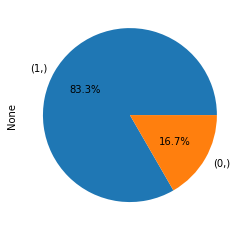

In [73]:
test = pd.read_csv('test_X.csv', sep=';')

predictions = my_pipeline.predict(test)

results = pd.DataFrame(predictions, columns=['final_status'])

results.to_csv('predicciones.csv', index=False)

ax = results.value_counts().plot(kind='pie', autopct='%1.1f%%')

predictions

The model predicts 5 cancellations out of the 30, which is a reasonable percentage (16.7%).

### 5.5. Conclusions

I've basically managed to increase the f1 macro score from 47% (predicting everything Delivered) to 52%, which should be around this number too in the test set. Even though it's still very far from 100%, it's a significant increase. In big business a small increase in performance could mean a lot of money saved.

Predicting behaviour from humans is in general a difficult task, and we don't have much detailed data from the requests, so even a perfect model probably wouldn't achieve close to 100% f1 macro score, so it's difficult to say whether we could do much better than what I achieved.

Further improve would be achieved basically by getting more variables: information about the users, what kind of products they bought, etc, as well as studying other successful cancell¡ation prediction models and what techniques they used to do so.

Overall I'm happy with the results I got cause I'm still quite new to Data Science and I didn't had a lot of time with the University work.